In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inf8245e-fall-2022/sample_submission.csv
/kaggle/input/inf8245e-fall-2022/train.csv
/kaggle/input/inf8245e-fall-2022/test.csv


# INF8245E - Machine Learning
## Fall 2022  - Kaggle competition - Concertgoers experience
### Team members
    - Sanmar SIMON 1938126
    - Matthew FORTIER 2216002
    - Jire Christian KANDOLO 1877163

In [49]:
# Any potential !pip install HERE
!pip install -U scikit-learn
!pip install -U xgboost
!pip install -U matplotlib
!pip install -U seaborn
!pip install -U lightgbm

import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Loading

In [50]:
raw_train_data = pd.read_csv(f'/kaggle/input/inf8245e-fall-2022/train.csv')
raw_test_data = pd.read_csv(f'/kaggle/input/inf8245e-fall-2022/test.csv')

## 2. Analysis of raw data

In [51]:
raw_train_data.isna().mean() # number of missing values

Id                                0.000000
Band Name                         0.005053
Band Genre                        0.005200
Band Country of Origin            0.004647
Band Debut                        0.005041
Concert ID                        0.005118
Concert Attendance                0.005265
Inside Venue                      0.004929
Rain                              0.005065
Seated                            0.004894
Personnality Trait 1              0.005012
Personnality Trait 2              0.004994
Personnality Trait 3              0.005253
Personnality Trait 4              0.005088
Concert Goer Age                  0.005018
Concert Goer ID                   0.004794
Height (cm)                       0.004982
Concert Goer Country of Origin    0.005053
Concert Enjoyment                 0.000000
dtype: float64

In [52]:
raw_train_data.describe()

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
count,169143.000000,169130.000000,1.691050e+05,169148.000000,169151.000000,169107.000000,169135.000000,169147.000000,169153.000000
mean,1985.895053,499.360587,2.727906e+05,0.030190,-7.776188,-0.017279,0.003432,46.979822,164.660680
std,16.365288,288.640600,1.641506e+07,0.992067,3237.713866,1.004774,1.006310,17.470503,14.365046
min,1955.000000,0.000000,5.400000e+01,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,140.000000
25%,1976.000000,249.000000,4.030000e+02,-0.638873,-0.689943,-0.711015,-0.698374,32.000000,152.000000
50%,1988.000000,500.000000,2.980000e+03,0.022664,-0.021836,0.010071,0.015264,47.000000,164.000000
75%,1998.000000,749.750000,2.202600e+04,0.698236,0.648032,0.680300,0.700369,63.000000,177.000000
max,2014.000000,999.000000,1.627540e+09,3.628828,325834.016795,3.308810,3.830923,76.000000,190.000000


### 2.1 Frequency of numerical features

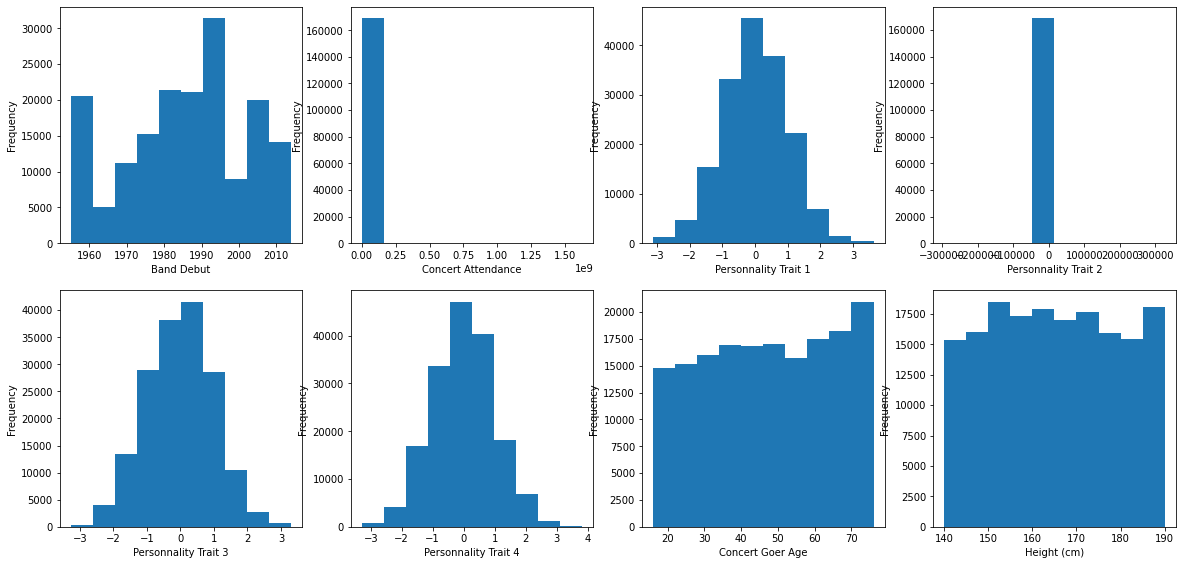

In [53]:
# Analyze the raw data
numerical_features = [features for features in raw_train_data.select_dtypes(include=np.number).columns.tolist() if features != 'Concert ID']
fig = plt.figure(figsize=(20, 20))
for i, feature in enumerate(numerical_features):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xlabel(feature)
    raw_train_data[feature].plot(kind='hist', ax=ax)

### 2.2 Categorical features vs Concert Enjoyment

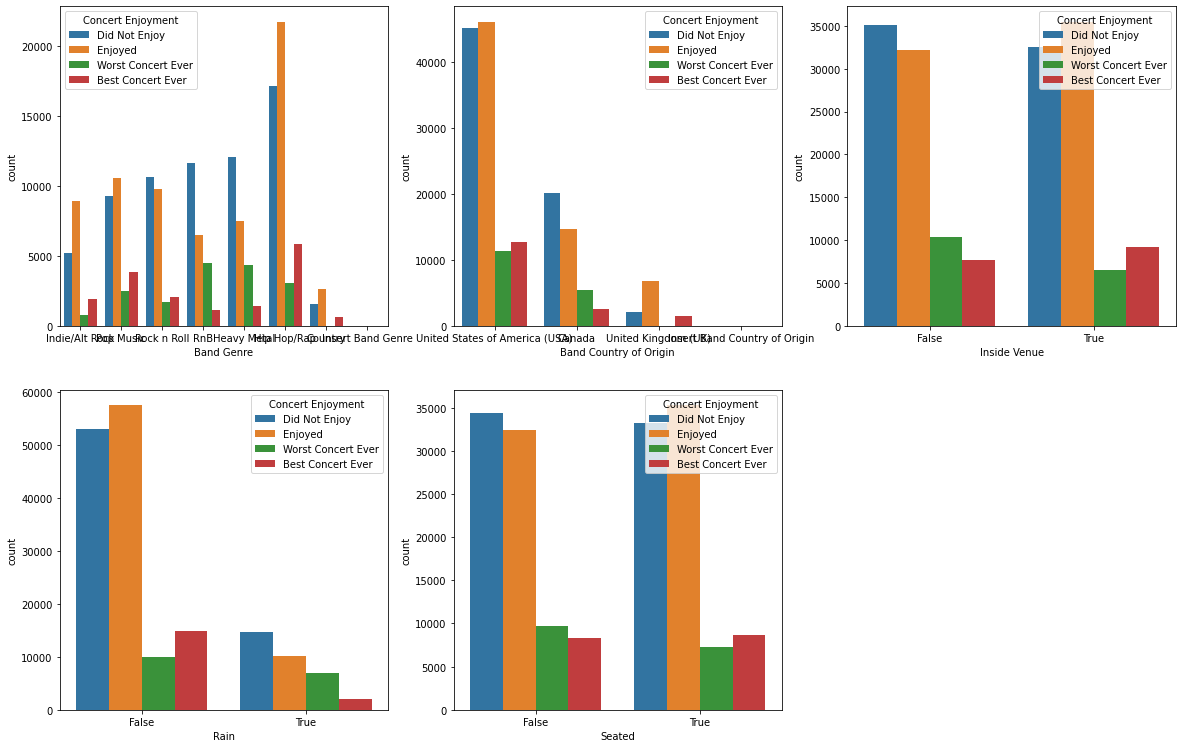

In [54]:
categorical_features = [feature for feature in raw_train_data.select_dtypes(include=['object']).columns.tolist() if raw_train_data[feature].nunique() < 10 and feature != 'Concert Enjoyment']
fig = plt.figure(figsize=(20, 20))
for i, feature in enumerate(categorical_features):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlabel(feature)
    chart = sns.countplot(x=feature, data=raw_train_data, hue='Concert Enjoyment', ax=ax)

### 2.3 Numerical features VS Concert Enjoyment

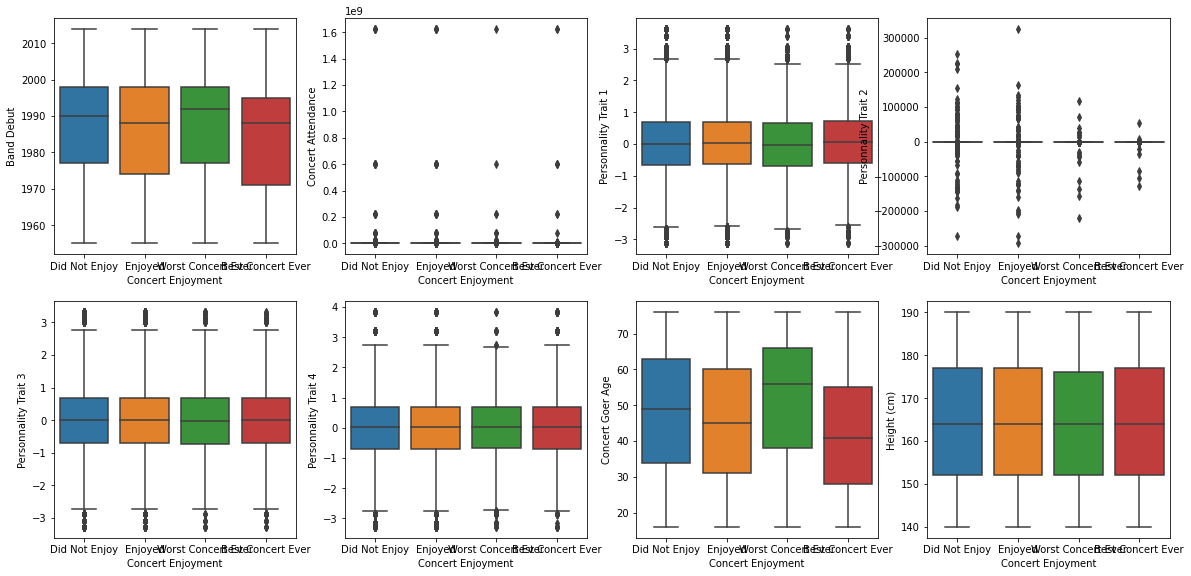

In [55]:
fig = plt.figure(figsize=(20, 20))

for i, feature in enumerate(numerical_features):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xlabel(feature)
    sns.boxplot(x='Concert Enjoyment', y=feature, data=raw_train_data, ax=ax)

## 3. Data preprocessing

When looking at both the train and test data above we notice that some values are not numerical, but also some are null values. That's why we will try to preprocess the value to make sure we don't have missing value or noises.

### 3.1 Handle missing values

In [56]:
# For each (k,v) pair here, if we know 'v', we can find 'k' from the data
dep_graph = {
    'Band Name': 'Concert ID',
    'Band Genre': 'Band Name',
    'Band Country of Origin': 'Band Name',
    'Band Debut': 'Band Name',
    'Concert Attendance': 'Concert ID',
    'Inside Venue': 'Concert ID',
    'Rain': 'Concert ID',
    'Personnality Trait 1': 'Concert Goer ID',
    'Personnality Trait 2': 'Concert Goer ID',
    'Personnality Trait 3': 'Concert Goer ID',
    'Personnality Trait 4': 'Concert Goer ID',
    'Concert Goer Age': 'Concert Goer ID',
    'Height (cm)': 'Concert Goer ID',
    'Concert Goer Country of Origin': 'Concert Goer ID'
}

data_map = {}
c_order = []
for att in ['Concert ID', 'Band Name', 'Concert Goer ID']:
    dependants = []
    for k,v in dep_graph.items(): # Get all dependant features
        if att == v:
            dependants.append(k)
    d = raw_train_data[dependants + [att]].groupby(att).agg(pd.Series.mode).to_dict('index')
    data_map.update(d) # Update the lookup table
    c_order.extend(dependants)

# data_map is now a dict which takes a Concert ID, Band Name, or Concert Goer ID, and returns clean values depending on that attribute.
# eg: 32.0: {'Band Name': 'Rubbish Devon Frogs', 'Concert Attendance': 2980.0, 'Inside Venue': True, 'Rain': False}
# eg: 'A Dozen Running Iced Frogs': {'Band Genre': 'Pop Music', 'Band Country of Origin': 'Canada', 'Band Debut': 1998.0}
# eg: 'concert_goer_218': {'Personnality Trait 1': 1.359525244743602, 'Personnality Trait 2': -0.1697117123652184, 'Personnality Trait 3': -1.4717159037967942, 'Personnality Trait 4': -0.7690807762719917, 'Concert Goer Age': 17.0, 'Height (cm)': 167.0, 'Concert Goer Country of Origin': 'Nepal'}    

def fill_NaN_deterministic(data):
    # define row-wise cleaning function
    def fill_NaN_row(row):
        for c in c_order:
            if pd.isnull(row.get(c)):
                row[c] = data_map.get(row[dep_graph[c]],{}).get(c)
        return row
    
    return data.apply(fill_NaN_row, axis=1)

# two things happenening here:
#   1. fill NaN values we can empirically determine. eg if we know the band name, we know the band debut & genre
#   2. Change boolean columns to [1, 0, -1] for [True, NaN, False]
def fill_missing_data(data):
    d = fill_NaN_deterministic(data)
    for c in ['Seated', 'Rain', 'Inside Venue']:
        d[c] = d[c].replace({True: 1, False: -1, np.nan: 0})
    return d

In [57]:
def remove_outliers(train_data, test_data, iterations=2):
    # Copy the data first, since this is a mutating function
    tr_data = train_data.copy()
    te_data = test_data.copy()
    # Hardcoded - two columns KNOWN to have MASSIVE outliers
    # Leave them as NaN for now, they can be imputed later
    for c in ['Concert Attendance', 'Personnality Trait 2']:
        # We do this twice, because in the first iteration, the STD is
        # so high, it doesn't even catch all the outliers.
        for i in range(iterations):
            median=tr_data[c].median()
            std=te_data[c].std()
            tr_outliers = (tr_data[c] - median).abs() > std
            te_outliers = (te_data[c] - median).abs() > std
            tr_data.loc[tr_outliers, c] = np.nan
            te_data.loc[te_outliers, c] = np.nan
    return tr_data, te_data

In [58]:
# For categorical, create a new category. For numerical, take the mean.
def custom_impute(train_data, test_data):
    tr = train_data.copy()
    te = test_data.copy()
    tr['Concert ID'] = tr['Concert ID'].astype(str)
    te['Concert ID'] = te['Concert ID'].astype(str)
    numerical_features = tr.select_dtypes(include=np.number).columns.tolist()
    string_features = tr.select_dtypes(include=object).columns.tolist()
    tr = tr.fillna({c: f'unknown_{c}' for c in string_features})
    tr[numerical_features] = tr[numerical_features].fillna(tr[numerical_features].mean())
    te = te.fillna({c: f'unknown_{c}' for c in string_features})
    te[numerical_features] = te[numerical_features].fillna(tr[numerical_features].mean()) # make sure to use training data means
    return tr, te


### 3.2 Feature scaling

In [59]:
from sklearn.preprocessing import StandardScaler

# We only want to scale some columns - eg don't scale boolean columns that were already converted to [-1,1]
def feature_scaling(train_data, test_data):
    tr = train_data.copy()
    te = test_data.copy()
    columns = [
        'Concert Attendance',
        #'Personnality Trait 1',
        #'Personnality Trait 2',
        #'Personnality Trait 3',
        #'Personnality Trait 4',
        'Concert Goer Age',
        'Height (cm)'
    ]
    scaler = StandardScaler()
    scaler.fit(tr[columns])  # Don't cheat - fit only on training data
    tr[columns] = scaler.transform(tr[columns])
    te[columns] = scaler.transform(te[columns]) # Test data
    return tr, te

### 3.3 Feature Engineering

The idea here is to take categorical columns that are not useful on their own (ex: Band Name), and turn them into something we can use.

In [60]:
# Transformation method.
# For each of [Band Name, Concert ID, Band Genre, Band Country, Attendee Country]:
#   replace these columns with their average enjoyment (ex: band "A" might avg enjoyment 2.13)
def feature_engineering(train_data, test_data, country_matching=False, band_personality_matrix=False, feature_score_frequencies=[], prune=[]):
    # Copy data so we don't mutate it
    tr = train_data.copy()
    te = test_data.copy()
    
    # Experiment: Change a column (such as Band Name) to score frequencies
    for c in feature_score_frequencies:
        vals = []
        for item in list(tr[c].unique()):
            t = tr[tr[c] == item]['Concert Enjoyment']
            t = t.value_counts(normalize=True).to_dict()
            vals.append((
                item,
                t.get('Best Concert Ever', 0.0),
                t.get('Enjoyed', 0.0),
                t.get('Did Not Enjoy', 0.0),
                t.get('Worst Concert Ever', 0.0),
            ))
        df = pd.DataFrame(vals, columns=[c, f'{c} Best%', f'{c} Enjoyed%', f'{c} Not Enjoyed%', f'{c} Worst%'])
        tr = tr.merge(df, left_on=c, right_on=c).sort_index()
        te = te.merge(df, left_on=c, right_on=c).sort_index()
        
    # Experiment: band personality matrix (adds 16 new columns)
    if band_personality_matrix:
        band_traits = {}
        for band in list(tr['Band Name'].unique()):
            t = tr[tr['Band Name'] == band]
            t = t[['Concert Enjoyment', 'Personnality Trait 1','Personnality Trait 2','Personnality Trait 3','Personnality Trait 4']]
            t = t.groupby('Concert Enjoyment').mean()
            d = {}
            for y in t.columns:
                for x in t.index:
                    d[f'{y}: {x}'] = t.loc[x,y]
            band_traits[band] = pd.Series(d)
        bt = pd.DataFrame(band_traits).transpose()
        tr = tr.merge(bt, left_on='Band Name', right_index=True).sort_index()
        te = te.merge(bt, left_on='Band Name', right_index=True).sort_index()

    
    # Map concert enjoyment to a numerical value
    tr.drop('Id', axis=1, inplace=True)
    tr['Concert Enjoyment'] = tr['Concert Enjoyment'].map({
        'Worst Concert Ever': 0.0,
        'Did Not Enjoy': 1.0,
        'Enjoyed': 2.0,
        'Best Concert Ever': 3.0
    })
    # If we're doing validation, 'Concert Enjoyment' will be in the test set.
    # Remove it.
    if 'Concert Enjoyment' in te.columns.to_list(): # this is a validation set
        te.drop('Id', axis=1, inplace=True)
        te['Concert Enjoyment'] = te['Concert Enjoyment'].map({
            'Worst Concert Ever': 0.0,
            'Did Not Enjoy': 1.0,
            'Enjoyed': 2.0,
            'Best Concert Ever': 3.0
        })
        
    # Experiment: home country
    if (country_matching):
        tr['home_country'] = tr.apply(lambda row: 1 if row['Concert Goer Country of Origin'] == row['Band Country of Origin'] else 0, axis=1)
        te['home_country'] = te.apply(lambda row: 1 if row['Concert Goer Country of Origin'] == row['Band Country of Origin'] else 0, axis=1)

    averaged_columns = ['Band Name', 'Concert ID', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin', 'Concert Goer ID']
    enjoyment_averages = {}
    for c in averaged_columns:
        agg = tr[[c, 'Concert Enjoyment']].groupby(c).mean()
        enjoyment_averages[c] = agg.to_dict()['Concert Enjoyment']
        
        tr[c] = tr[c].map(enjoyment_averages[c])
        te[c] = te[c].map(enjoyment_averages[c])
    
    for c in prune:
        tr.drop(c, axis=1, inplace=True)
        te.drop(c, axis=1, inplace=True)
    
    return tr, te

### 3.5 Check for highly correlated features

In [61]:
# Not currently using this, but keeping it because it will be VERY useful for the analysis later.

#train_correlation = raw_train_data.corr()
#plt.figure(figsize=(10,6))
#sns.heatmap(train_correlation, annot=True)

from sklearn.model_selection import KFold

def prepare_data(tr_data, te_data, feature_params):
    # Remove outliers
    tr_data, te_data = remove_outliers(tr_data, te_data)
    
    # Impute remaining NaNs, or create dummy classes for categorical features
    tr_data, te_data = custom_impute(tr_data, te_data)
    
    # Scale numerical features
    tr_data, te_data = feature_scaling(tr_data, te_data)
    
    # Feature engineering
    tr_data, te_data = feature_engineering(tr_data, te_data, **feature_params)
    return tr_data, te_data

## 4. Classification

In [62]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, plot_confusion_matrix

### 4.1 Test different models

In [63]:
def run_experiment(model, data, k_folds=5, feature_params={}):
    kf = KFold(n_splits=k_folds)
    kf.get_n_splits(data)
    predictions = []
    targets = []
    for i, (train_index, val_index) in enumerate(kf.split(data)):
        print(f'Iteration {i}:')
        train_data = data.loc[train_index]
        val_data = data.loc[val_index]
        
        print('  Preparing data...')
        train_data, val_data = prepare_data(train_data, val_data, feature_params)
        X_train = train_data.loc[ : , train_data.columns != 'Concert Enjoyment']
        y_train = train_data['Concert Enjoyment'].astype('int')
        X_val = val_data.loc[ : , val_data.columns != 'Concert Enjoyment']
        y_val = val_data['Concert Enjoyment'].astype('int')
        
        print('  Training model...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        predictions.extend(list(y_pred))
        targets.extend(list(y_val))
        
    return classification_report(targets, predictions)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, Dataset

models = []
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
#models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Gradient Boosting', HistGradientBoostingClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Neural Network', MLPClassifier((32,32))))
models.append(('XGBoost', XGBClassifier()))
models.append(('LightGBM', LGBMClassifier()))

train_data = fill_missing_data(raw_train_data)
test_data = fill_missing_data(raw_test_data)

In [65]:
# Test all models
"""for model in models:
    report = run_experiment(model[1], train_data)
    print(model[0])
    print(report)"""

'for model in models:\n    report = run_experiment(model[1], train_data)\n    print(model[0])\n    print(report)'

In [66]:
# Test single model
"""# Try adding Concert Goer ID to the averages
params = {
    'country_matching': True,
    'band_personality_matrix': True,
    'prune': []
}
vals = []

model = LGBMClassifier()
accuracy = run_experiment(model, train_data, k_folds=5, feature_params=params)
print(accuracy)
"""

"# Try adding Concert Goer ID to the averages\nparams = {\n    'country_matching': True,\n    'band_personality_matrix': True,\n    'prune': []\n}\nvals = []\n\nmodel = LGBMClassifier()\naccuracy = run_experiment(model, train_data, k_folds=5, feature_params=params)\nprint(accuracy)\n"

### 4.2 Fine tuning of selected model

In [67]:
# Hyperparameter tuning
"""params = {
    'country_matching': True,
    'feature_score_frequencies': ['Band Name', 'Concert ID'],
    'prune': []
}
vals = []
for i in range(10):
    eta = np.random.uniform(0.2,0.3)
    max_depth = np.random.randint(6,10)
    model = XGBClassifier(eta=eta, max_depth=max_depth)
    r = run_experiment(model, train_data, k_folds=10, feature_params=params)
    vals.append((eta, max_depth, r['accuracy']))
    print(eta,max_depth,r['accuracy'])
    

# scatterplot
d = {'eta': [], 'max_depth': [], 'accuracy': []}
for eta, md, a in vals:
    d['eta'].append(eta)
    d['max_depth'].append(md)
    d['accuracy'].append(a)

df = pd.DataFrame(d)
#df.plot.scatter(x='eta',y='max_depth', c='accuracy')
sns.scatterplot(df, x='eta', y='max_depth', hue='accuracy')"""

"params = {\n    'country_matching': True,\n    'feature_score_frequencies': ['Band Name', 'Concert ID'],\n    'prune': []\n}\nvals = []\nfor i in range(10):\n    eta = np.random.uniform(0.2,0.3)\n    max_depth = np.random.randint(6,10)\n    model = XGBClassifier(eta=eta, max_depth=max_depth)\n    r = run_experiment(model, train_data, k_folds=10, feature_params=params)\n    vals.append((eta, max_depth, r['accuracy']))\n    print(eta,max_depth,r['accuracy'])\n    \n\n# scatterplot\nd = {'eta': [], 'max_depth': [], 'accuracy': []}\nfor eta, md, a in vals:\n    d['eta'].append(eta)\n    d['max_depth'].append(md)\n    d['accuracy'].append(a)\n\ndf = pd.DataFrame(d)\n#df.plot.scatter(x='eta',y='max_depth', c='accuracy')\nsns.scatterplot(df, x='eta', y='max_depth', hue='accuracy')"

### 4.3 Predictions

In [68]:
params = {
    'country_matching': True,
    'feature_score_frequencies': ['Band Name', 'Concert ID'],
    'prune': []
}
model = XGBClassifier(eta=0.2, max_depth=9)

prepared_train_data, prepared_test_data = prepare_data(train_data, test_data, params)
X_train = prepared_train_data.loc[ : , prepared_train_data.columns != 'Concert Enjoyment']
y_train = prepared_train_data['Concert Enjoyment'].astype('int')
X_test = prepared_test_data.loc[ : , prepared_test_data.columns != 'Id']
ids = prepared_test_data['Id']
print('  Training model...')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

import json
D = {x: str(y) for x, y in zip(model.feature_names_in_, model.feature_importances_)}
print(json.dumps(D, indent=4))


"""
X_train = eng_tr.loc[ : , eng_tr.columns != 'Concert Enjoyment']
y_train = eng_tr['Concert Enjoyment'].astype('int')
X_test = eng_te
ids = X_test['Id']
params = {'learning_rate': 0.10, 'boosting_type': 'gbdt', 'objective': 'regression', 'num_leaves': 150, 'max_depth': 20}
model = LGBMClassifier(**params)
model.fit(X_train, y_train)
predictions = model.predict(X_test.drop('Id', axis=1))
"""

  Training model...
{
    "Band Name": "0.015893925",
    "Band Genre": "0.010272022",
    "Band Country of Origin": "0.016209459",
    "Band Debut": "0.018740438",
    "Concert ID": "0.025802653",
    "Concert Attendance": "0.008084735",
    "Inside Venue": "0.0077593136",
    "Rain": "0.0074437824",
    "Seated": "0.036802933",
    "Personnality Trait 1": "0.007956608",
    "Personnality Trait 2": "0.007872433",
    "Personnality Trait 3": "0.0097208535",
    "Personnality Trait 4": "0.007925981",
    "Concert Goer Age": "0.02471738",
    "Concert Goer ID": "0.039441817",
    "Height (cm)": "0.0080873",
    "Concert Goer Country of Origin": "0.0098472405",
    "Band Name Best%": "0.012836473",
    "Band Name Enjoyed%": "0.0106812185",
    "Band Name Not Enjoyed%": "0.009760187",
    "Band Name Worst%": "0.013488257",
    "Concert ID Best%": "0.14869164",
    "Concert ID Enjoyed%": "0.13135776",
    "Concert ID Not Enjoyed%": "0.14048058",
    "Concert ID Worst%": "0.19985951",
    "h

"\nX_train = eng_tr.loc[ : , eng_tr.columns != 'Concert Enjoyment']\ny_train = eng_tr['Concert Enjoyment'].astype('int')\nX_test = eng_te\nids = X_test['Id']\nparams = {'learning_rate': 0.10, 'boosting_type': 'gbdt', 'objective': 'regression', 'num_leaves': 150, 'max_depth': 20}\nmodel = LGBMClassifier(**params)\nmodel.fit(X_train, y_train)\npredictions = model.predict(X_test.drop('Id', axis=1))\n"

### 4.4 Writing submission file

In [69]:
output = pd.DataFrame({ 'Id' : ids, 'Predicted': predictions })

output['Predicted'] = output['Predicted'].replace(0, "Worst Concert Ever")
output['Predicted'] = output['Predicted'].replace(1, "Did Not Enjoy")
output['Predicted'] = output['Predicted'].replace(2, "Enjoyed")
output['Predicted'] = output['Predicted'].replace(3, "Best Concert Ever")

output.to_csv('submission.csv', index=False)